In [1]:
pip install timesfm

In [2]:
from timesfm import TimesFm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0].


In [3]:
%%time

import timesfm

# Initialize the TimeSFM model
tm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=64,
          horizon_len=480, # output default 128
          num_layers=50,
          use_positional_embedding=False,
          context_len=4096, # input defaut 2048
      ),
      checkpoint= timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 5.8 s, sys: 2.86 s, total: 8.66 s
Wall time: 17.1 s


In [4]:
# Load the dataset
import pandas as pd
import numpy as np
data = pd.read_csv("/content/weatherHistory.csv")


In [5]:
# Convert the temperature data to a NumPy array
temperature_data = data['Temperature (C)'].values  # Shape: (num_hours,)

# Extract the past year's hourly temperature data (last 8760 hours)
input_context = temperature_data[:4096]  # Last year's data

forecast_input = [input_context]  # Wrap in a list as required by TimesFm
frequency_input = [1]  # Hourly frequency

In [6]:
# Generate predictions
point_forecast, experimental_quantile_forecast = tm.forecast(
    forecast_input,
    freq=frequency_input,
)

# Extract the point forecast (predicted temperatures)
predicted_temperatures = point_forecast[0]  # First element corresponds to the first time series

In [7]:
predicted_temperatures

array([ 2.17288551e+01,  1.58553829e+01,  1.61622543e+01,  1.56538944e+01,
        1.87562008e+01,  1.18882198e+01,  1.62914505e+01,  1.67530766e+01,
        1.54348040e+01,  2.08960915e+01,  1.79539776e+01,  1.66426430e+01,
        1.53833551e+01,  1.51435652e+01,  1.79370499e+01,  1.32214251e+01,
        1.43168297e+01,  1.29943256e+01,  1.50952425e+01,  1.52871952e+01,
        1.67619286e+01,  1.32313452e+01,  9.99992371e+00,  9.42231560e+00,
        1.28811970e+01,  7.98831367e+00,  9.61384392e+00,  8.24247456e+00,
        1.25247526e+01,  7.68435383e+00,  9.51503754e+00,  1.14828281e+01,
        1.45342560e+01,  1.65030289e+01,  1.96192799e+01,  1.93571701e+01,
        1.76294727e+01,  1.10055723e+01,  1.09877892e+01,  1.37619448e+01,
        8.76059246e+00,  9.05152416e+00,  9.54795742e+00,  1.33222380e+01,
        1.26305313e+01,  1.41184387e+01,  1.56574669e+01,  1.22114658e+01,
        1.51510744e+01,  1.29414444e+01,  1.77672844e+01,  1.02103567e+01,
        1.28918114e+01,  

In [8]:
len(predicted_temperatures)

480

In [9]:
actual_temperatures = data['Temperature (C)'].values[4096:4576]  # Last 128 hours of data

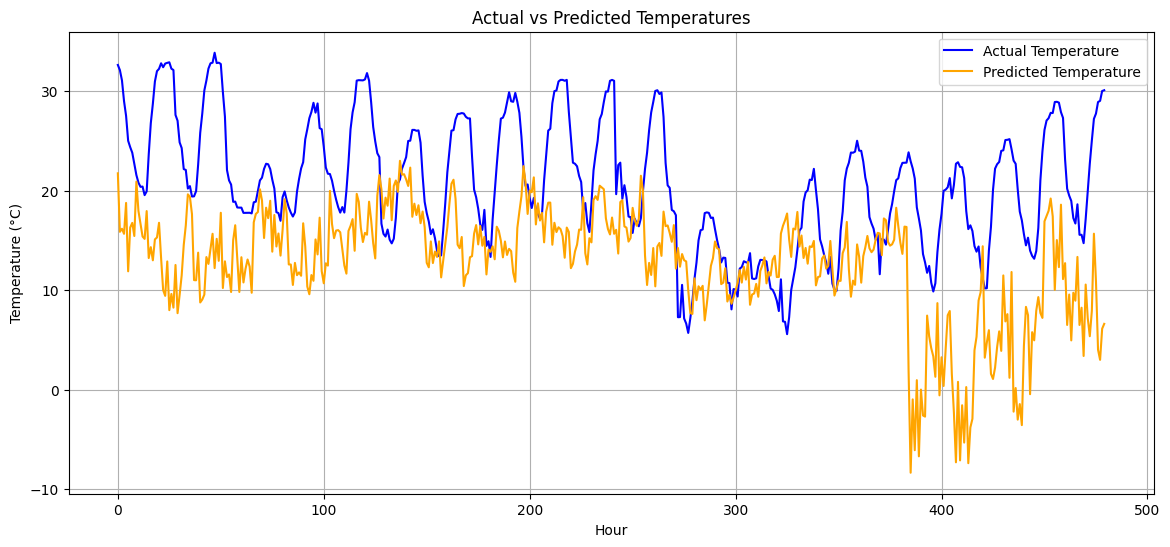

In [10]:
import matplotlib.pyplot as plt

# Plot actual vs predicted temperatures
plt.figure(figsize=(14, 6))
plt.plot(actual_temperatures, label='Actual Temperature', color='blue')
plt.plot(predicted_temperatures, label='Predicted Temperature', color='orange')
plt.xlabel('Hour')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperatures')
plt.legend()
plt.grid()
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate evaluation metrics
mae = mean_absolute_error(actual_temperatures, predicted_temperatures)
rmse = np.sqrt(mean_squared_error(actual_temperatures, predicted_temperatures))

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f} °C")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} °C")

Mean Absolute Error (MAE): 8.69 °C
Root Mean Squared Error (RMSE): 11.01 °C
